Category
                                                       size
Category       Item                                        
Rent           Rent                                       1
books          THE COMMERCIAL PRESS01100 HONG KONG        1
cash withdraw  cash withdraw                              1
electronics    CHUNG YUEN ELECTRICA53225 HONG KONG        1
entertainment  BOSE - MOKO STORE                          1
               ITUNES.COM/BILL 85221120099                1
               PLAYSTATION NETWO TOKYO                    1
grocery        ALIPAY *AlipayHK                           1
               ALIPAY *PARKnSHOP HK                       1
               AlipayHK*                                  1
               AlipayHK*PARKnSHOP HK                     11
               FUSION 478 JP SS                           5
               WELLCOME  006                              1
home/clothing  AlipayHK*MUJI HONG KON                     1
               IKEA - 004                                 2
               MANGO                                      1
               MUJI (HONG KONG) COMPANY  MONGKOK          1
               POPULAR BOOK COMPANY LIMI MONGKOK          1
               SOGO HONG KONG CO LTD                      1
pet            DOG.COM                                    1
               MEGAPET                                    1
restaurant     NENE CHICKEN                               1
               PACIFIC COFFEE CO LTD (QE JORDAN           1
               PETIT PRET                                 2
               PHD - SHOP 621                             1
               PRET A MANGER                              1
               SEN-RYO - 5081                             1
transportation OCTOPUS 67265175 ADD­VALU                  5
               OCTOPUS 67291059 ADD­VALU                  3
utility        CHINA MOBILE HONG KONG                     2
               Electricity                                1
               HKBN­RESD SERVICES                         1
               Water                                      1

29855


,Amount_HKD,percentage
Category,,
Rent,14000,46.9
electronics,3230,10.8
home/clothing,2895,9.7
cash withdraw,2000,6.7
transportation,2000,6.7
entertainment,1836,6.1
grocery,1558,5.2
utility,887,3.0
restaurant,731,2.4


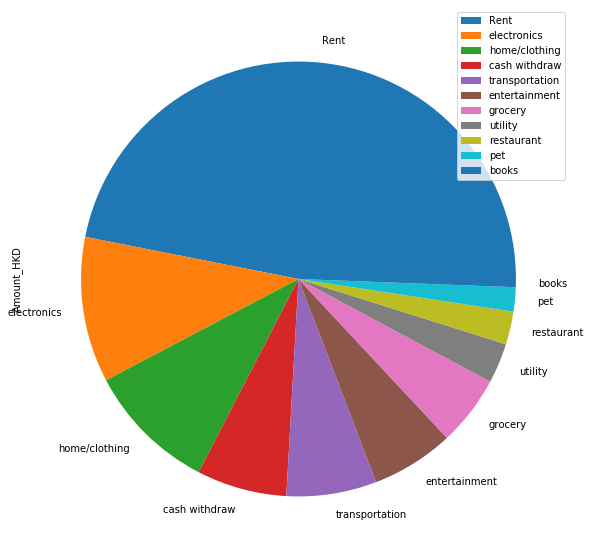

In [37]:
import tabula
import pandas as pd
import numpy as np
import re
# display unnecessary warnings and errors
import warnings
warnings.filterwarnings('ignore')
import sys
sys.stderr = open('/dev/null', 'w')
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline


# ===== local file locations =====
file_citi_bank = '/Users/Charles/Desktop/Others-HK/bank statement/citi bank statement/eStatement_2019_06_24.pdf'
file_hsbc_bank = '/Users/Charles/Desktop/Others-HK/bank statement/hsbc/hsbc_2019_06_11.pdf'


# ===== citi =====
# stream option is for not hard gird lines, it imports table by spacings based on the area.
# Area was gotten by cropping the pdf (left, top, top+height, left+width)
citi = tabula.read_pdf(file_citi_bank, area=(269.86, 43.07, 615.58, 551.93), stream=True, pages=3)
# clean up the raw pdf format
citi = citi[0].replace('\r',' ', regex=True)
citi = citi.iloc[:,[0,4]]
citi = citi.reset_index(drop=True)
# remove unrelated rows
citi = citi[citi.iloc[:, 0].map(lambda x: re.search('[A-Z]{3}\ [0-9]{2}\ [0-9]{2}', x) != None)]
# extract the date column
citi['Date'] = citi.iloc[:, 0].apply(lambda x: re.search('[A-Z]{3}\ [0-9]{2}\ [0-9]{2}', x).group(0))
# extract the items column
citi['Item'] = citi.iloc[:, 0].apply(lambda x: re.split('[A-Z]{3}\ [0-9]{2}\ [0-9]{2}', x, 1)[1])
citi = citi.iloc[:, 1:4]
# name columns names
citi.columns = ['Amount_HKD', 'Date', 'Item']
# reorder columns
citi = citi.loc[:, ['Date', 'Item', 'Amount_HKD']]


# ===== hsbc =====
hsbc = tabula.read_pdf(file_hsbc_bank, area=(224.29, 61.68, 502.64, 570.86), stream=True, pages=1)
hsbc = hsbc[0].replace('\r',' ', regex=True)
hsbc = hsbc.iloc[:,[1, 2, 5]]
hsbc = hsbc.reset_index(drop=True)
hsbc.columns = ['Date', 'Item', 'Amount_HKD']

# ===== more data cleaning =====
# combine citi and hsbc ebanking statements
spending = pd.concat([citi, hsbc]).reset_index(drop=True)
spending.dropna(subset=['Date'], how='all', inplace=True)
spending.Item = spending.Item.astype(str)
# cleanup extra spaces in the items column
spending.Item = spending.Item.str.strip()
spending.Amount_HKD = spending.Amount_HKD.astype(str)
# remove the credit items in the dataframe
spending = spending[spending['Amount_HKD'].map(lambda x: re.search('CR$', x) == None)]
# cleanup the non-numeric characters in the amout column
spending['Amount_HKD'] = spending['Amount_HKD'].apply(lambda x: re.sub(' ', '', x))
spending['Amount_HKD'] = spending['Amount_HKD'].apply(lambda x: re.sub(',', '', x))
spending.Amount_HKD = spending.Amount_HKD.astype(float)
spending.Amount_HKD = spending.Amount_HKD.astype(int)
# remove rows containing the work BALANCE
spending = spending[spending['Item'].map(lambda x: re.search('BALANCE$', x) == None)]
spending.Date.astype(str, inplace=True)
# make the date column having uniform format
def Fixdate(x):
    try:
        x = dt.datetime.strptime(x, '%b %d %y')
    except:
        x = dt.datetime.strptime(x+'19', '%d%b%y')
    return x
spending.Date = spending.Date.apply(lambda x: Fixdate(x))
spending.set_index('Date', inplace=True)
spending.sort_index(inplace=True)
# group each spending to specific category
def Category(x):
    a = 'grocery'
    b = 'utility'
    c = 'restaurant'
    d = 'pet'
    e = 'entertainment'
    f = 'home/clothing'
    g = 'transportation'
    h = 'electronics'
    i = 'books'
    if x == 'ALIPAY *AlipayHK':
        return a
    elif re.search('PARKnSHOP', x):
        return a
    elif x == 'AlipayHK*':
        return a
    elif re.search('MUJI', x):
        return f
    elif x == 'CHINA MOBILE HONG KONG':
        return b
    elif x == 'HKBN­RESD SERVICES':
        return b
    elif x == 'TUNES.COM/BILL 8522112009':
        return e
    elif x == 'MANGO':
        return f
    elif re.search('OCTOPUS', x):
        return g
    elif x == 'PLAYSTATION NETWO TOKYO':
        return e
    elif x == 'BOSE - MOKO STORE':
        return e
    elif x == 'CHUNG YUEN ELECTRICA53225 HONG KONG':
        return h
    elif x == 'DOG.COM':
        return d
    elif x == 'FUSION 478 JP SS':
        return a
    elif x == 'IKEA - 004':
        return f
    elif x == 'MEGAPET':
        return d
    elif x == 'NENE CHICKEN':
        return c
    elif x == 'PACIFIC COFFEE CO LTD (QE JORDAN':
        return c
    elif x == 'PETIT PRET':
        return c
    elif x == 'PHD - SHOP 621':
        return c
    elif x == 'POPULAR BOOK COMPANY LIMI MONGKOK':
        return f
    elif x == 'PRET A MANGER':
        return c
    elif x == 'SEN-RYO - 5081':
        return c
    elif x == 'SOGO HONG KONG CO LTD':
        return f
    elif x == 'THE COMMERCIAL PRESS01100 HONG KONG':
        return i
    elif re.search('^WELLCOME', x):
        return a
    elif re.search('ITUNES', x):
        return e
    return ''
spending['Category'] = spending['Item'].apply(Category)
# append monthly rent and other items paid by cash
spending = spending.append(pd.DataFrame(data={'Item': ['Rent', 'Water', 'Electricity', 'cash withdraw'], 
                                              'Amount_HKD': [14000, 200, 200, 2000], 
                                              'Category': ['Rent', 'utility', 'utility', 'cash withdraw']}, index=[dt.datetime(2019, 6, 22), dt.datetime(2019, 6, 22), dt.datetime(2019, 6, 22), dt.datetime(2019, 6, 22)]))
# display(spending.head(90))
with open('/Users/Charles/Downloads/bank_statement_analysis_total.html' ,'w') as f:
    spending.to_html(f)
    

# ===== aggregation =====
display(spending.groupby(['Category', 'Item']).agg({'Category': ['size']}))
agg1 = spending.groupby(['Category', 'Item']).agg({'Category': ['size']})
with open('/Users/Charles/Downloads/bank_statement_analysis_categories.html' ,'w') as f:
    agg1.to_html(f)
agg2 = spending.groupby(['Category']).agg({'Amount_HKD': 'sum'})
agg2['percentage'] = round(100 * agg2.Amount_HKD / sum(agg2.Amount_HKD), 1)
agg2.sort_values(by='percentage', inplace=True, ascending=False)
with open('/Users/Charles/Downloads/bank_statement_analysis_percentage.html' ,'w') as f:
    agg2.to_html(f)
print(sum(agg2.Amount_HKD))
display(agg2)
agg2.plot.pie('Amount_HKD', figsize=(10, 10))

